<a href="https://colab.research.google.com/github/davkeem/SHAZAM-CAPSTONE/blob/main/shazam_query_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')

mfcc_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/mfcc'
hist_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/hist_data'
chroma_data_folder = '/content/drive/My Drive/SHAZAM-CAPSTONE-main/SHAZAM-CAPSTONE-main/processed_chroma/ml_processed_data'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This loads the csv files, skips the first row and column of labels, and pads the histogram array to match up with the mfcc array.

Expected data shapes:
X shape: (20, 550, 14)
y shape: (20, 550, 1)

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, skiprows=1)
            data.append(df.iloc[:, 1:].values)  # Exclude the time bin column
    max_length = max(array.shape[0] for array in data)  # Determine max length
    padded_data = pad_sequences(data, maxlen=max_length, padding='post', dtype='float32')  # Pad sequences
    return np.array(padded_data)

# Load MFCC, chroma, and histogram data
X_mfcc = load_data(mfcc_data_folder)  # MFCC data
X_chroma = load_data(chroma_data_folder)  # Chroma data
y = load_data(hist_data_folder)  # Histogram data

# Check if MFCC and chroma data have the same shape and concatenate
if X_mfcc.shape[1] != X_chroma.shape[1]:
    raise ValueError("MFCC and chroma data must have the same number of time steps.")

X = np.concatenate((X_mfcc, X_chroma), axis=-1)  # Concatenate along the last axis

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")




X shape: (20, 550, 27)
y shape: (20, 550, 1)


Work In Progress

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training on Song 1
Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4782518.5000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 4082978.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 3463843.2500
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 2924895.0000
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 2259329.7500
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1861362.7500
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 1436949.7500
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 1174507.0000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 933076.6250
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 777863.5000
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 647836.8750
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 582447.0625
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 482358.3750
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 459

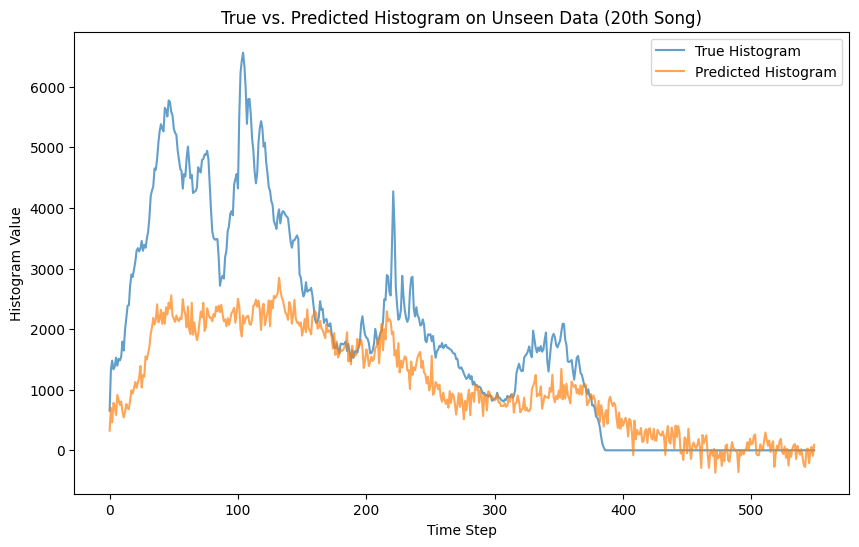

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


loo = LeaveOneOut()

# Split the data
X_train = X[:19]  # First 19 songs for training
y_train = y[:19]
X_test = X[19:]   # 20th song for testing
y_test = y[19:]

# Build the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(550, 27)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(550, activation='linear'))  # 550 time steps
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, callbacks=[early_stopping])

# Evaluate the model on the unseen test song
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE on Unseen Data: {loss}")

# Make predictions
y_pred = model.predict(X_test).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
print(f"Test RMSE on Unseen Data: {rmse}")

# Plot the true vs. predicted histograms
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='True Histogram', alpha=0.7)
plt.plot(y_pred, label='Predicted Histogram', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Histogram Value')
plt.title('True vs. Predicted Histogram on Unseen Data')
plt.legend()
plt.show()


My first attempt at LOO (Leave One Out) Cross Validation modeling.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5898040.5000
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 5366406.5000
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 4871195.0000
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 4404440.5000
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 3964528.0000
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 3552009.2500
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 3168268.7500
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 2814891.0000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 2493309.0000
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 2204502.7500
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 1948898.1250
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 1726313.6250
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 1535909.6250
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 1376161.3750
Epoc

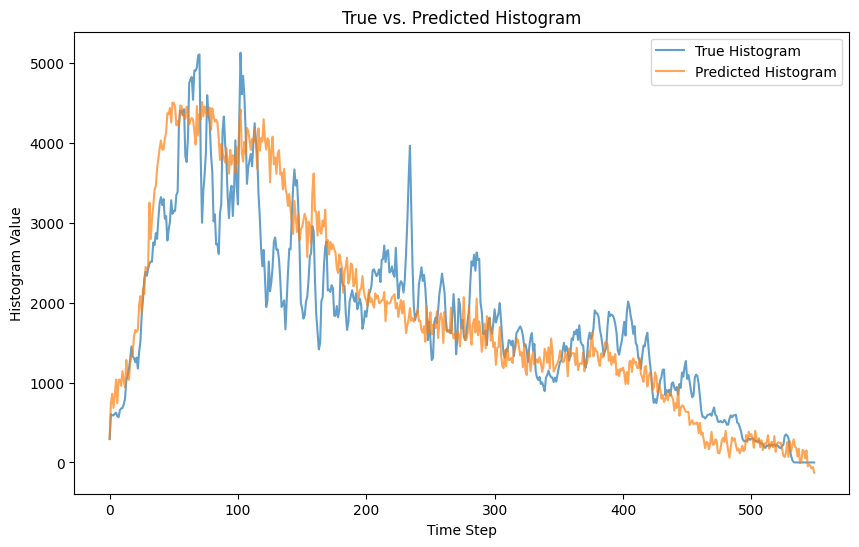

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 607056.8125
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step - loss: 597374.7500
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 587818.3125
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - loss: 578365.3125
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 568990.7500
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step - loss: 559718.3125
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 550546.5000
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 541474.5000
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 532502.5625
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 523612.9062
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 514762.6250
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 505879.7812
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 496920.0000
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 487806.7812
Epoch 15/40
1/1

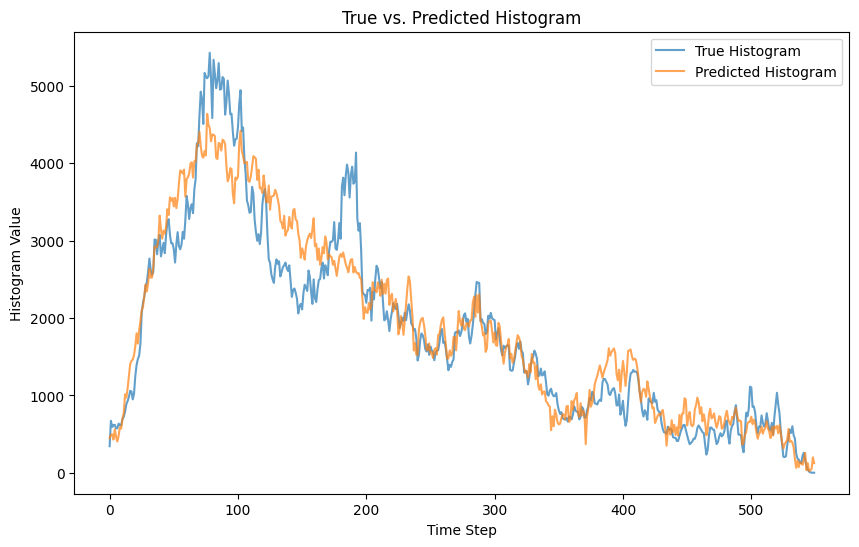

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 202907.0781
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 193556.4531
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 184474.1562
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 175844.6719
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 167667.6719
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 159883.3906
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - loss: 152408.2812
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step - loss: 145209.3750
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - loss: 138329.0625
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - loss: 131802.1250
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - loss: 125660.7344
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - loss: 119885.4453
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 114446.3672
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 109345.6953
Epoch 15/40
1/1

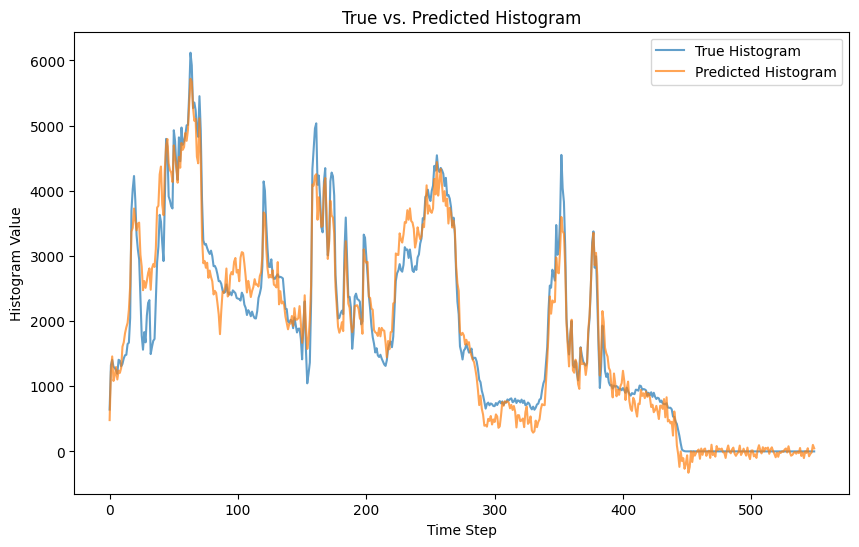

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 32803.7305
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 31182.9531
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 29827.7754
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 28430.8613
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 26872.5312
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 25367.0762
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 24020.0039
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 22692.5684
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 21400.3047
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 20231.9219
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - loss: 19146.7070
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - loss: 18118.4316
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step - loss: 17176.8301
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - loss: 16312.9834
Epoch 15/40
1/1 ━━━━━━━━━━━━━

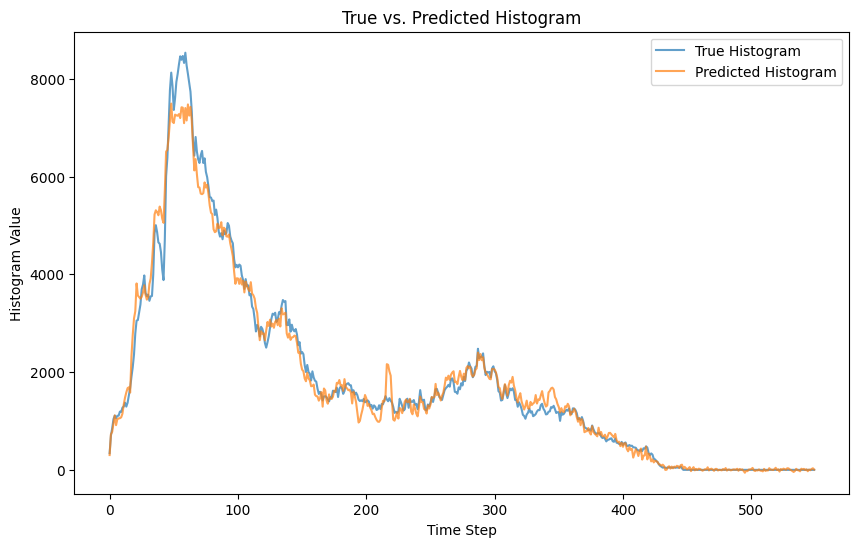

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 7210.4604
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 6830.3774
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 6636.8867
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 6282.9771
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 5888.4761
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 5560.3403
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 5247.6152
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 4906.0181
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 4597.4927
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 4331.0200
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 4068.3191
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 3809.6230
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 3580.8083
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step - loss: 3369.3091
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621

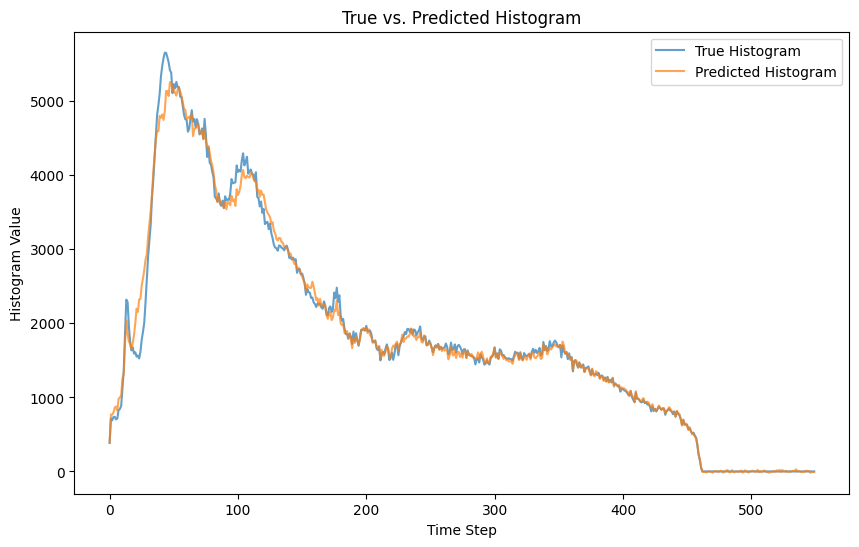

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 1646.8369
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 1573.4290
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 1561.4576
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 1496.7673
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 1447.0516
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 1409.1910
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 1356.4037
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 1308.7981
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 1273.0590
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 1230.3531
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 1194.2804
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 1160.3143
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 1126.0189
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 1095.3257
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313

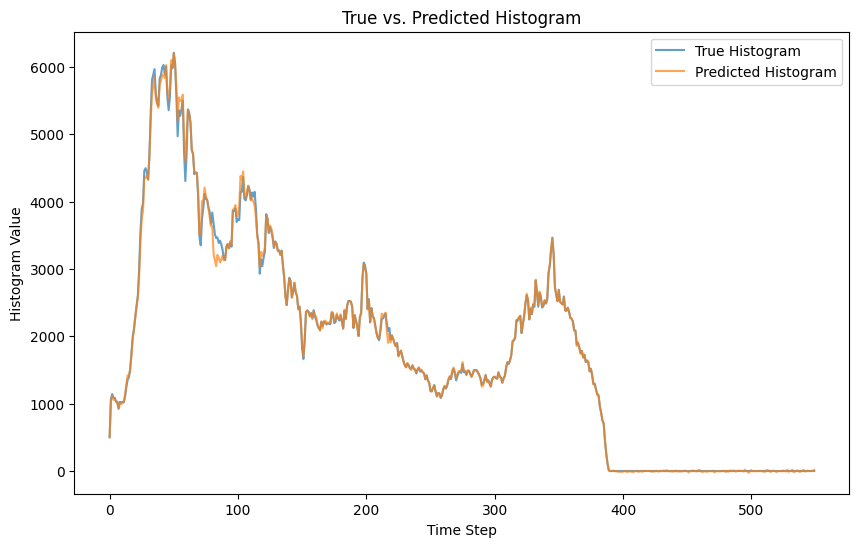

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 683.2017
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 654.5740
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 645.5618
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 619.1946
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 598.6336
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 580.0503
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 555.9085
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 533.7907
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 515.2345
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 499.5992
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 485.0138
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 472.6429
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 459.0258
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 443.7943
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss

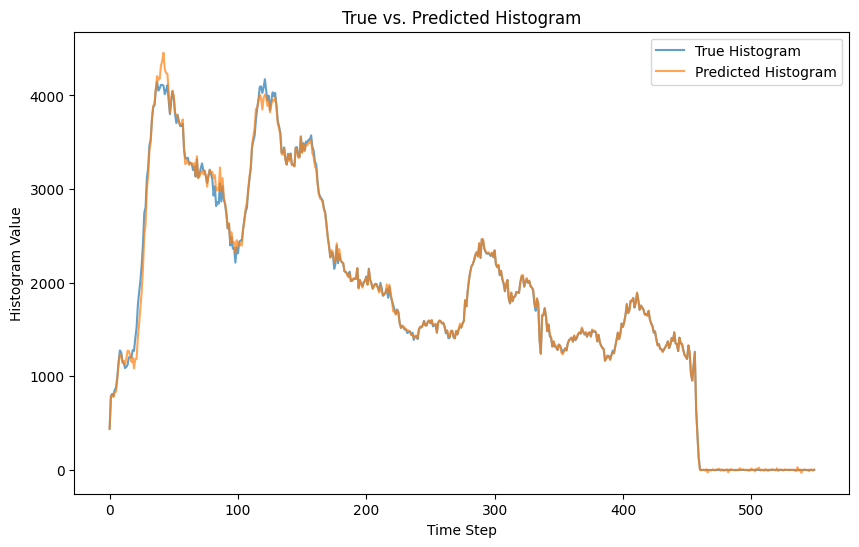

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 343.3247
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 331.3253
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 332.2687
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 316.8733
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 301.9603
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 295.3889
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 288.4595
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 281.3294
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 269.4905
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 260.6629
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 255.1922
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 246.1355
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 239.0206
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 233.3998
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss

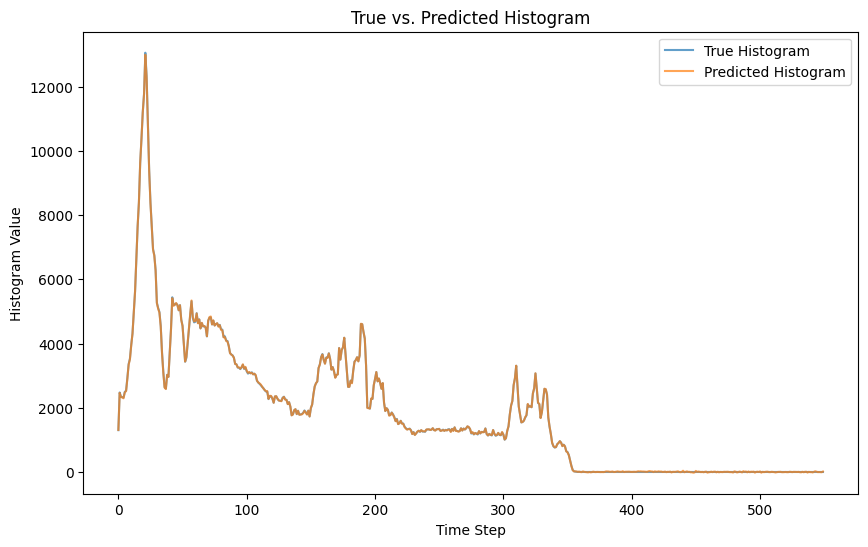

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 166.3866
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 165.1639
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 161.0143
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 151.2538
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 140.2388
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 133.7857
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 131.8212
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 129.7465
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 124.1525
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 117.0984
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 111.5423
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 107.4925
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 104.2035
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 101.7186
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss

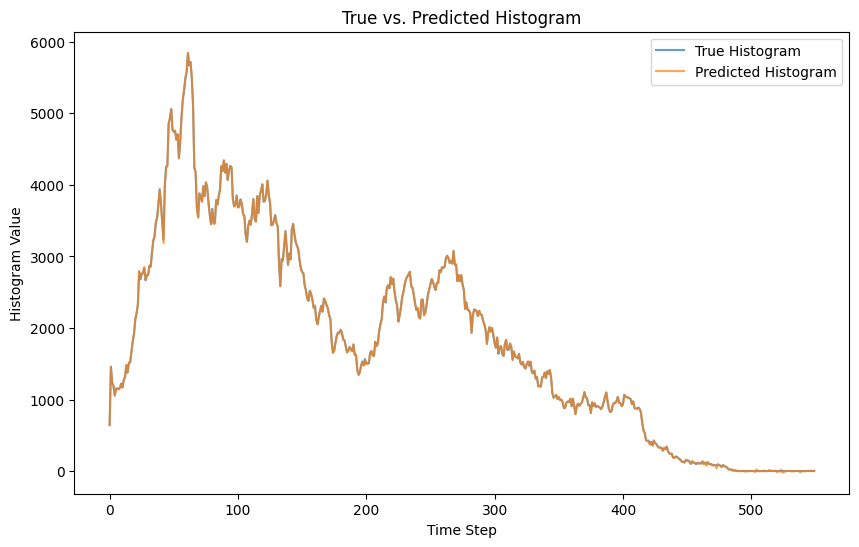

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 62.3543
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 63.9691
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 66.7752
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 69.9481
Test MSE for this fold: 38.1690559387207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 6.178110599517822


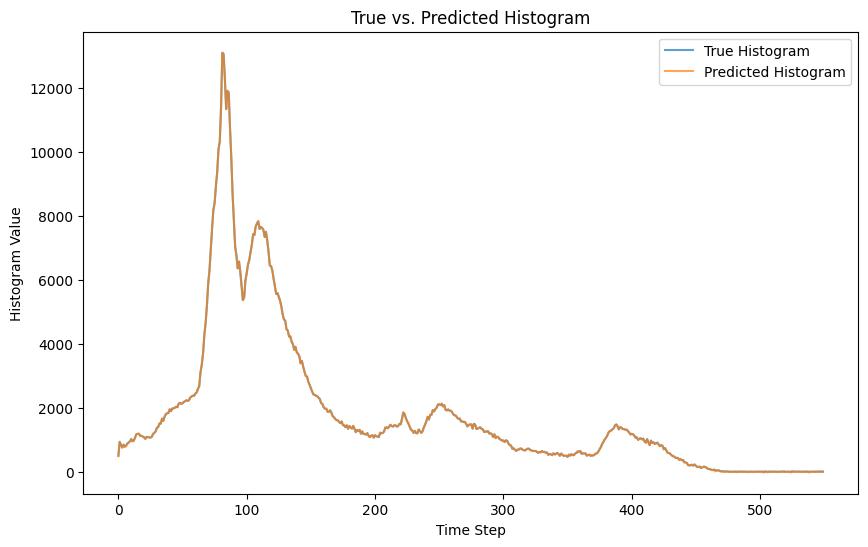

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 73.5299
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 78.3236
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 85.0178
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 93.3095
Test MSE for this fold: 71.22602844238281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 8.43955135345459


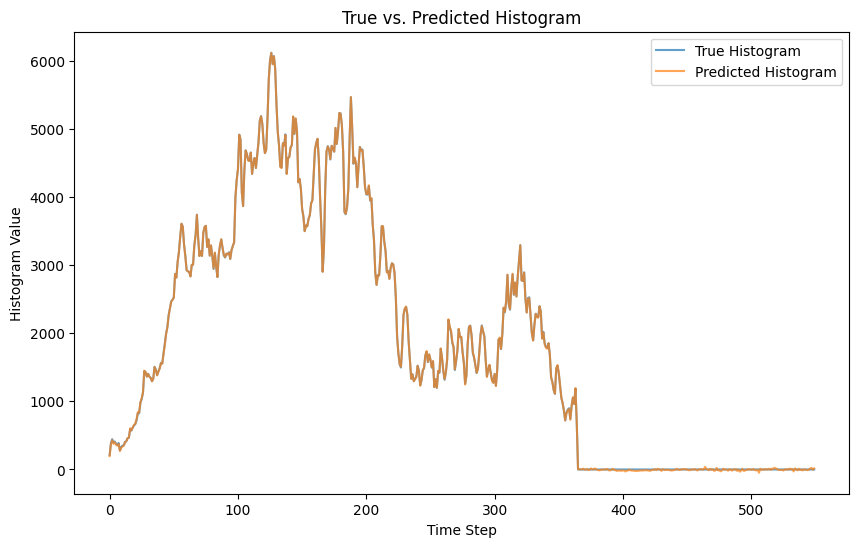

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 98.5550
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 96.8867
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 88.4175
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 78.5459
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 70.9786
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 67.4581
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 67.7894
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 69.1220
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 66.9743
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 60.0214
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 53.0102
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 50.4969
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 50.8980
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 49.1808
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 44.2838
Epoc

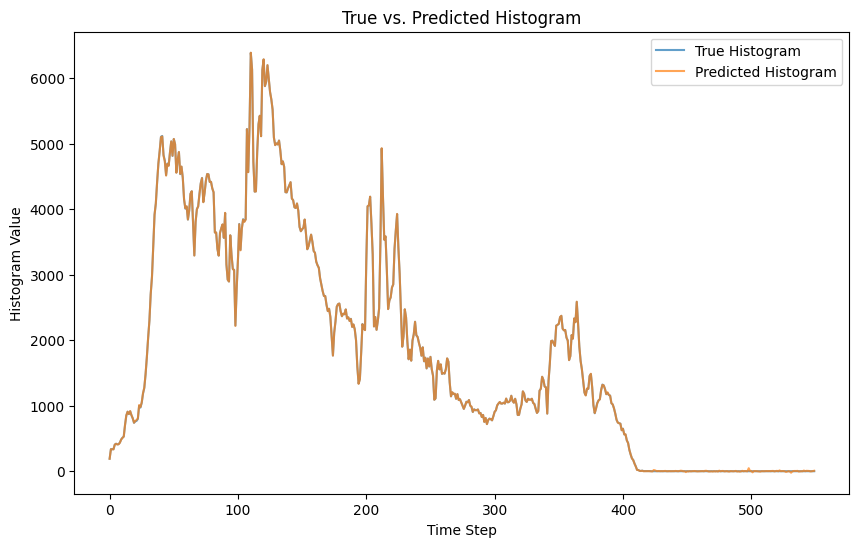

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 25.6329
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 26.3952
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 25.6895
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 22.8941
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 21.0082
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 22.4051
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 25.1156
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 25.7544
Test MSE for this fold: 14.399077415466309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE for this fold: 3.7946114540100098


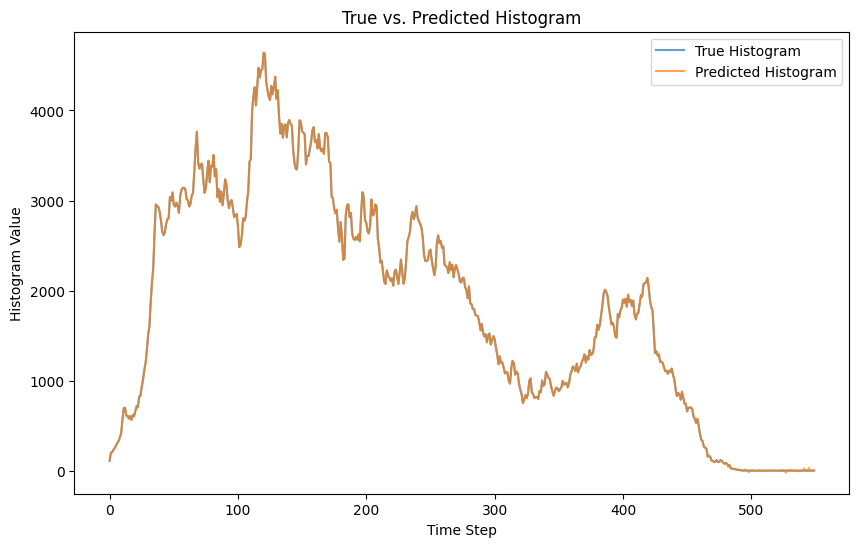

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 24.8231
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 25.6460
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 29.0976
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 32.2678
Test MSE for this fold: 21.46600914001465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 4.633142471313477


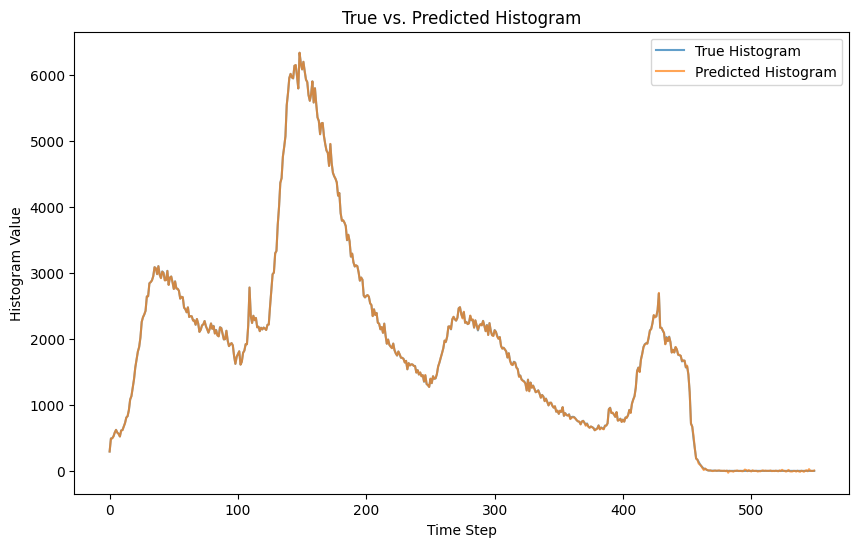

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 33.8399
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 35.4378
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 38.5481
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 42.8245
Test MSE for this fold: 42.001590728759766
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test RMSE for this fold: 6.480863571166992


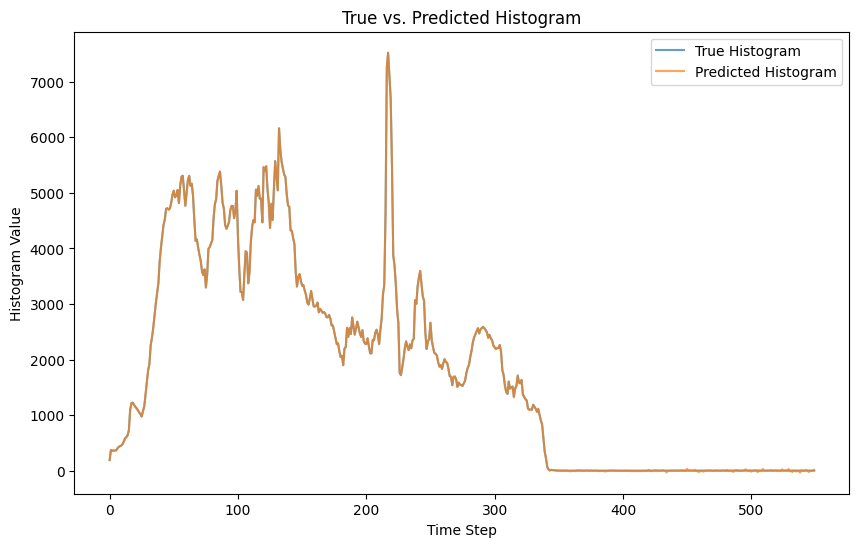

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 48.4036
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 55.1376
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 60.0808
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 61.3261
Test MSE for this fold: 53.80259323120117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test RMSE for this fold: 7.335025310516357


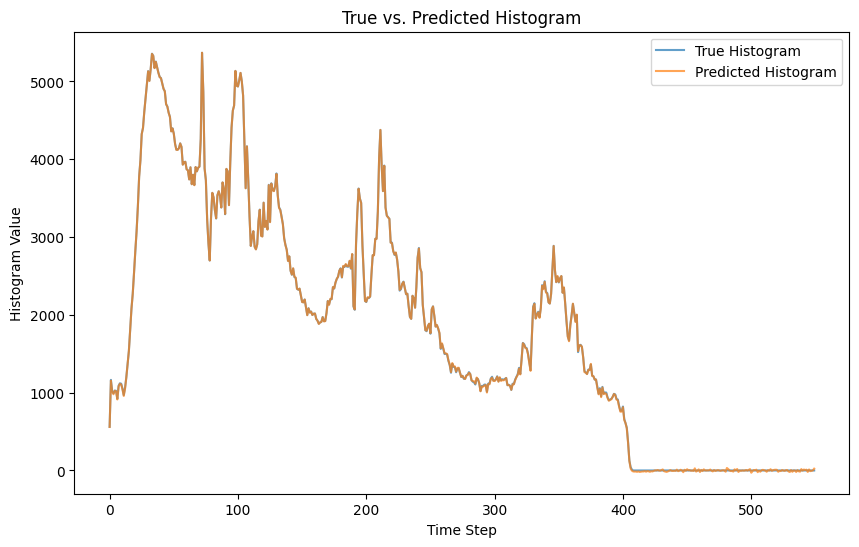

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 62.3962
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 69.6421
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 80.9713
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 89.8028
Test MSE for this fold: 73.77479553222656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Test RMSE for this fold: 8.589225769042969


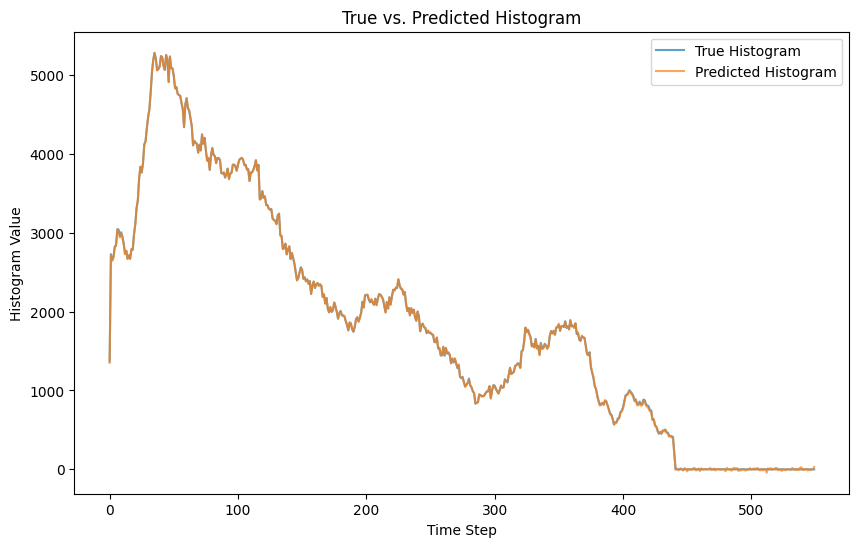

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 90.2360
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 82.1504
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 67.0158
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - loss: 50.5096
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - loss: 38.3834
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 34.0544
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - loss: 34.9330
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 36.0173
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step - loss: 35.4668
Test MSE for this fold: 30.11981201171875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Test RMSE for this fold: 5.488152027130127


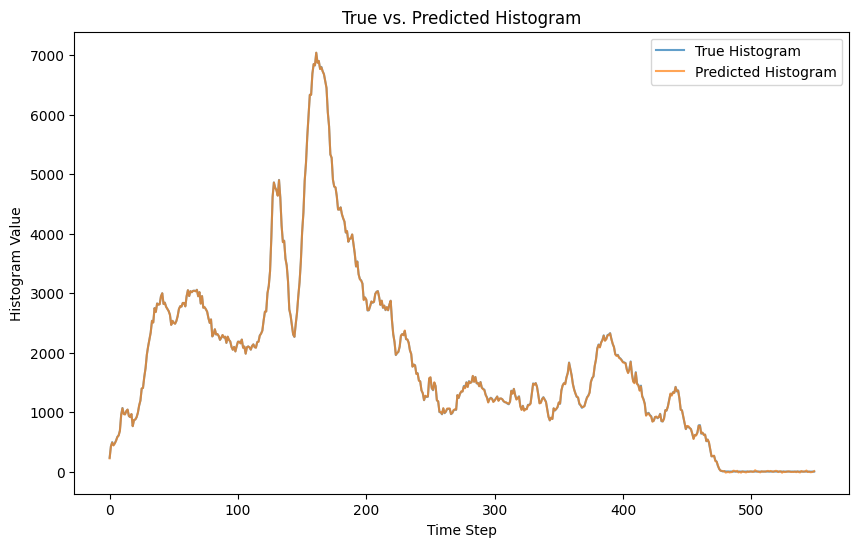

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 34.6088
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 33.7777
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 30.9488
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 26.1335
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 22.0315
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 20.8524
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 21.6427
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 21.9231
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 20.9310
Test MSE for this fold: 14.441490173339844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test RMSE for this fold: 3.8001961708068848


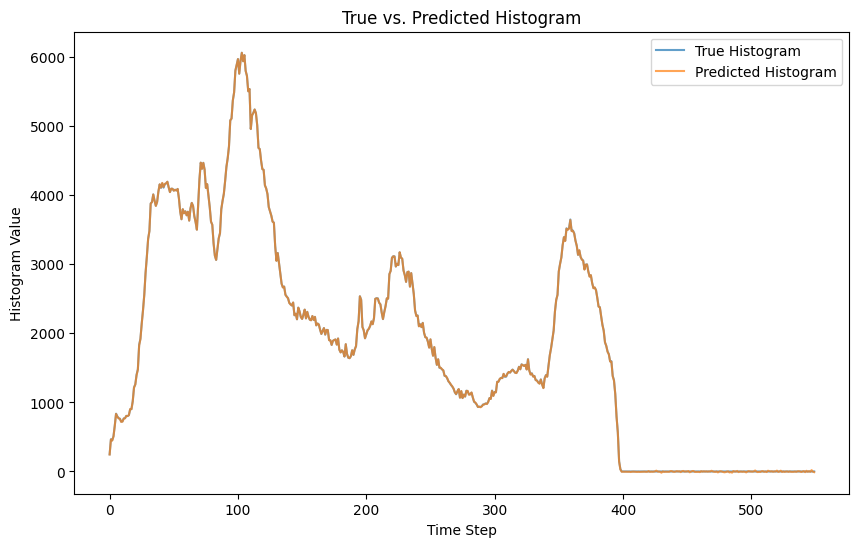

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 19.2500
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 17.5660
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 15.5604
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 13.5776
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 12.5213
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 12.5653
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 12.8496
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 12.6300
Test MSE for this fold: 13.049171447753906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE for this fold: 3.612363576889038


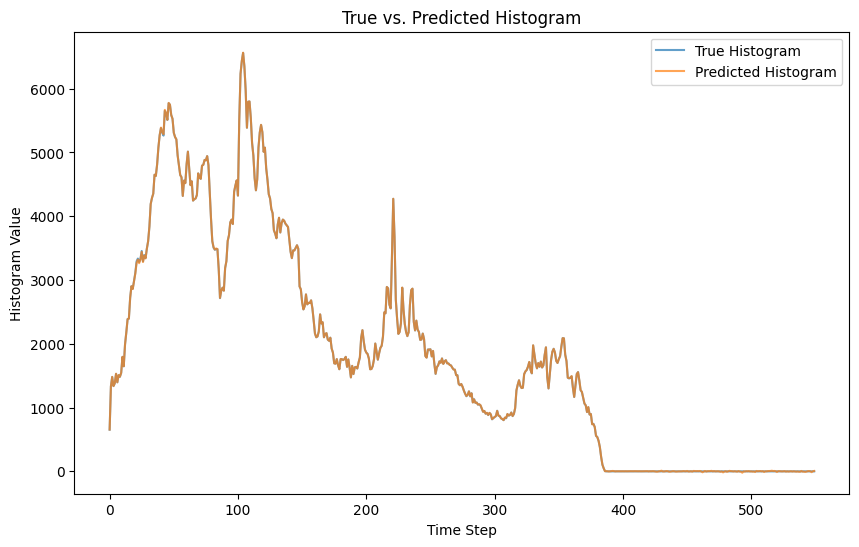


--- Final Validation ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Song 1 - Final Validation RMSE: 2.944283962249756


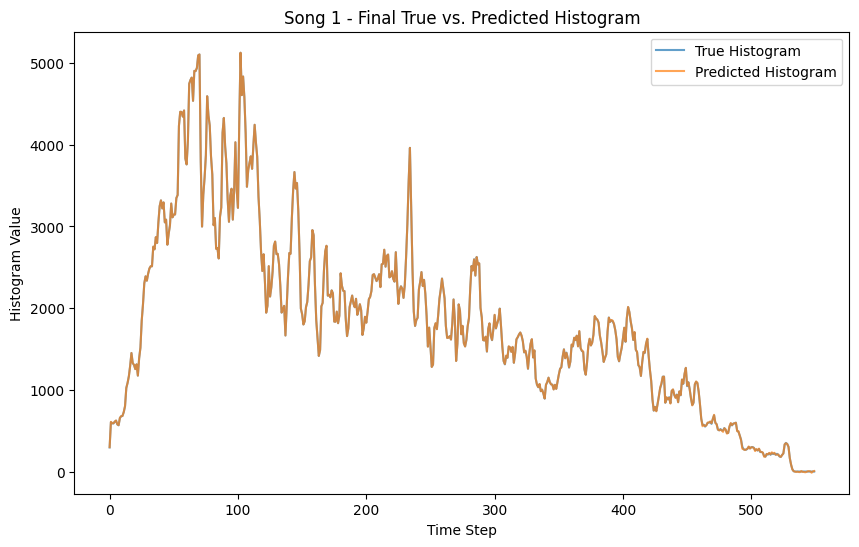

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Song 2 - Final Validation RMSE: 2.8652071952819824


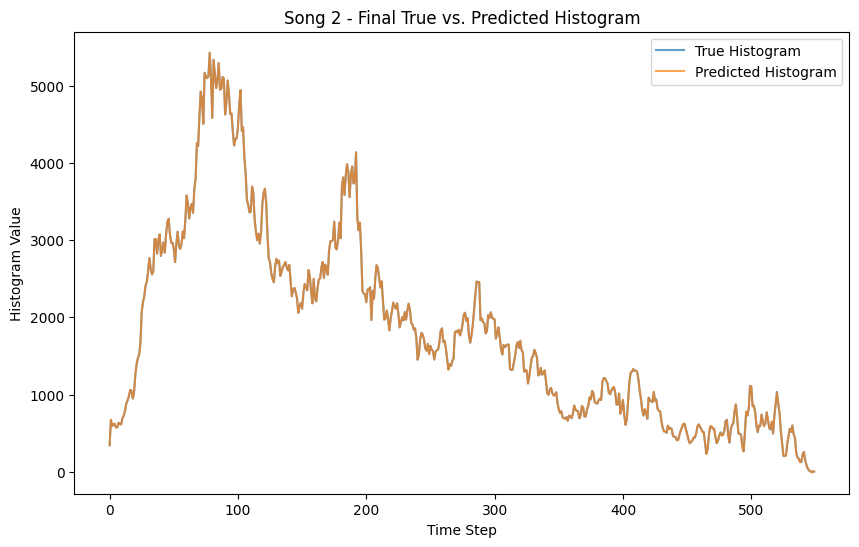

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Song 3 - Final Validation RMSE: 3.026954412460327


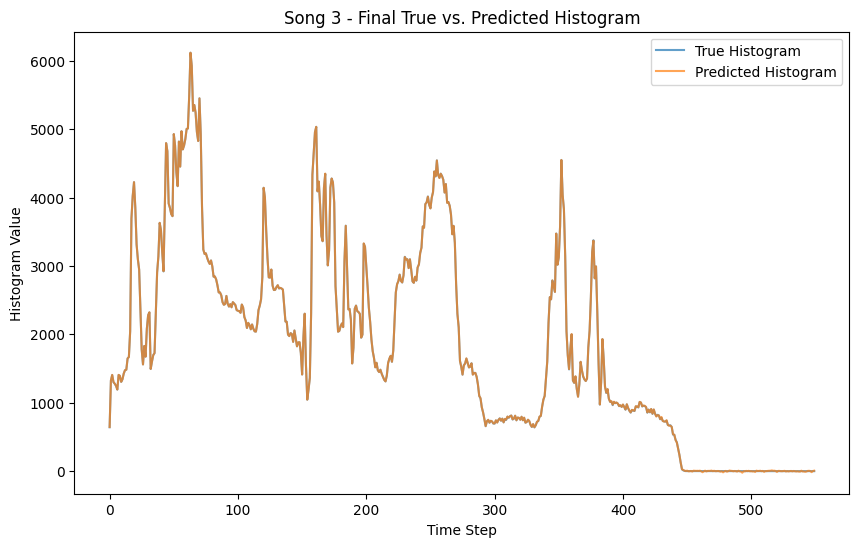

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Song 4 - Final Validation RMSE: 3.58432936668396


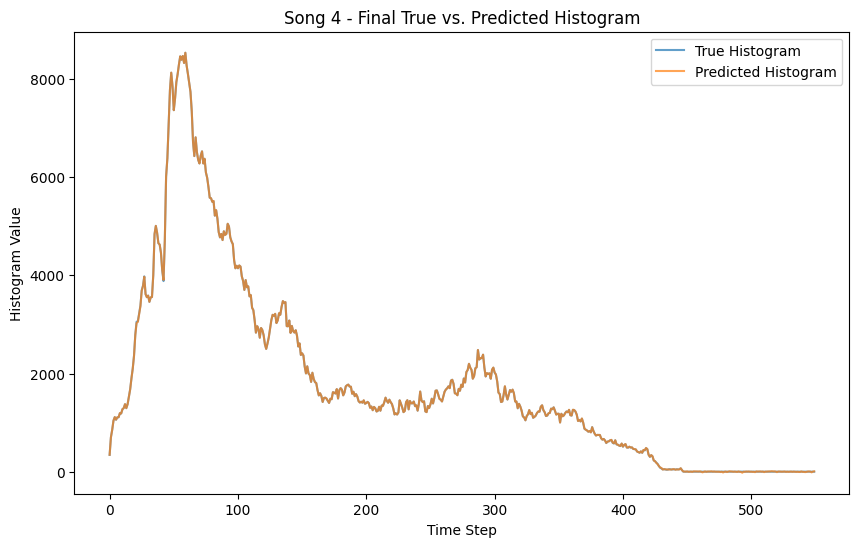

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Song 5 - Final Validation RMSE: 8.27753734588623


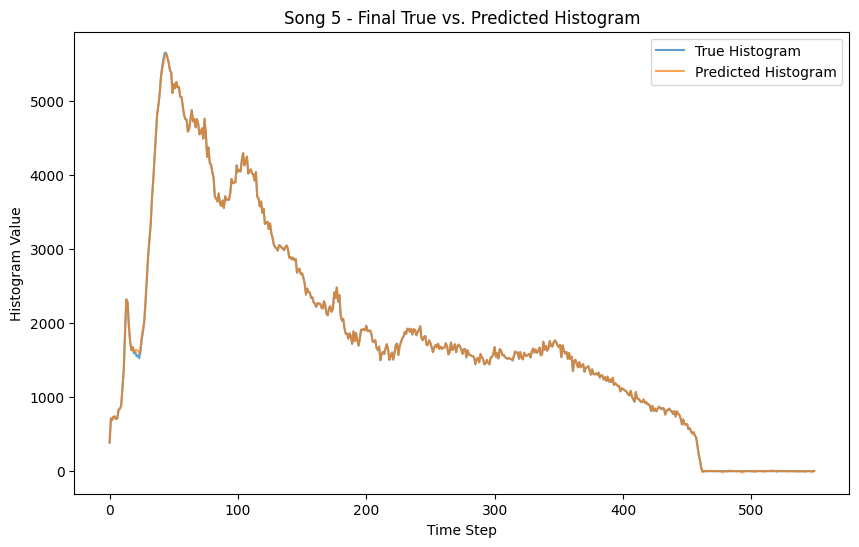

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Song 6 - Final Validation RMSE: 2.7959718704223633


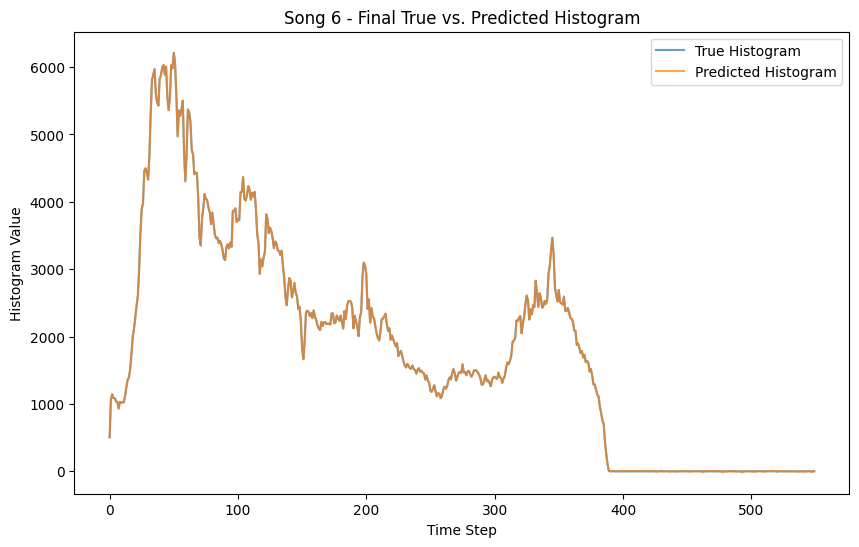

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Song 7 - Final Validation RMSE: 4.398311138153076


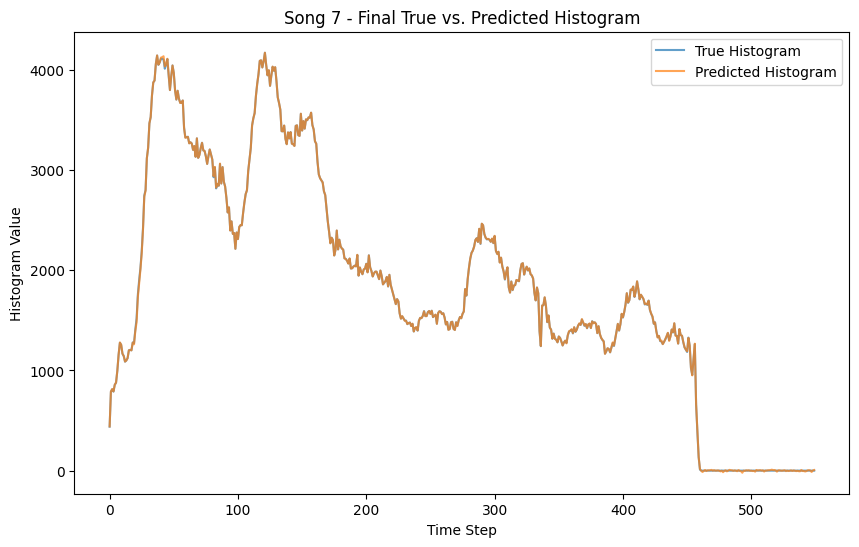

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Song 8 - Final Validation RMSE: 2.856461524963379


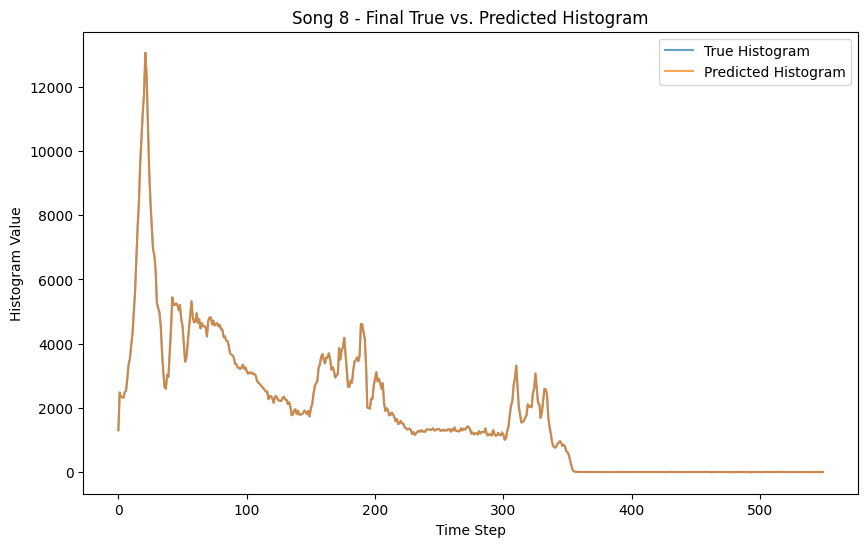

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Song 9 - Final Validation RMSE: 2.811434745788574


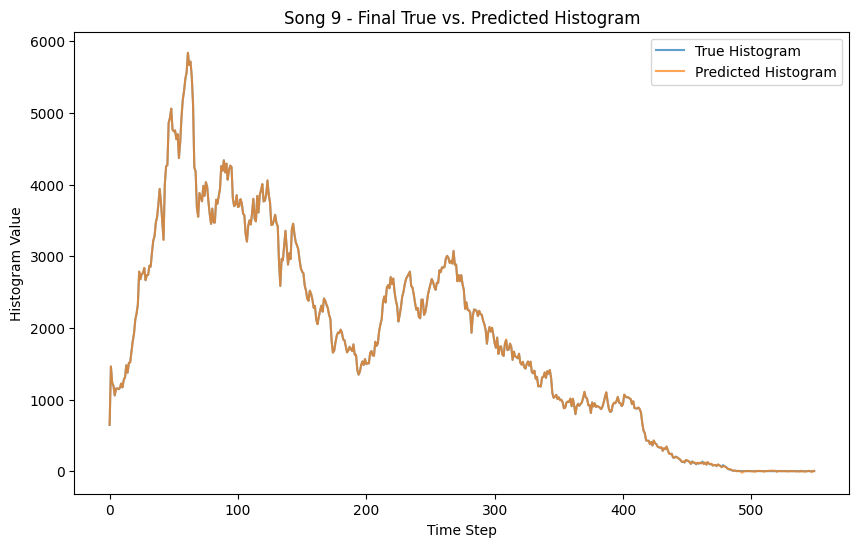

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Song 10 - Final Validation RMSE: 2.826789617538452


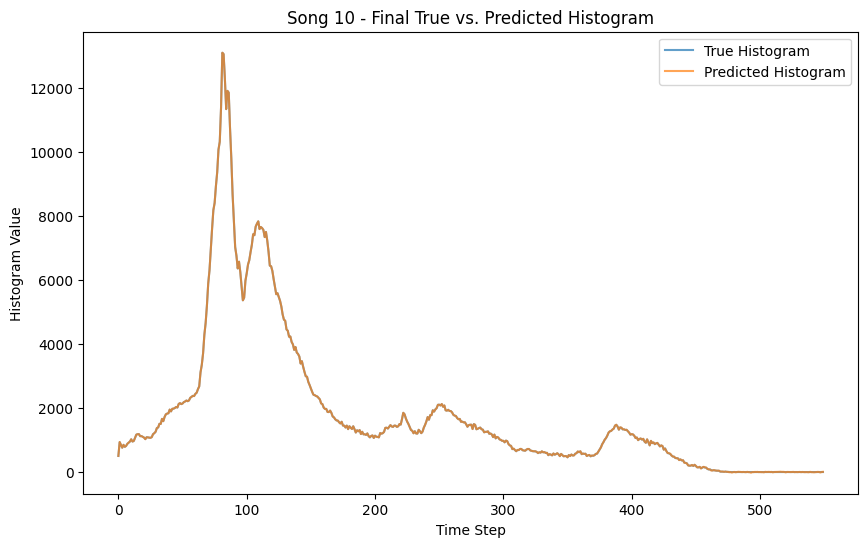

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Song 11 - Final Validation RMSE: 2.8683691024780273


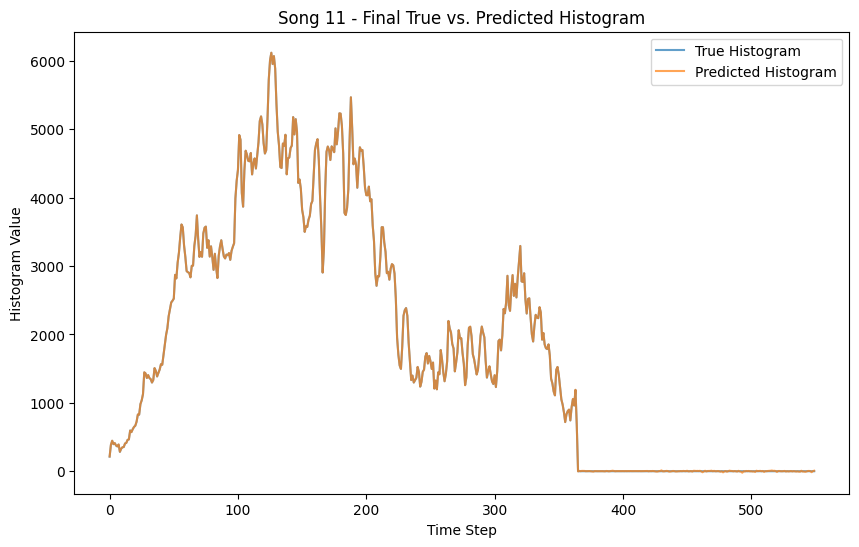

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Song 12 - Final Validation RMSE: 2.8903071880340576


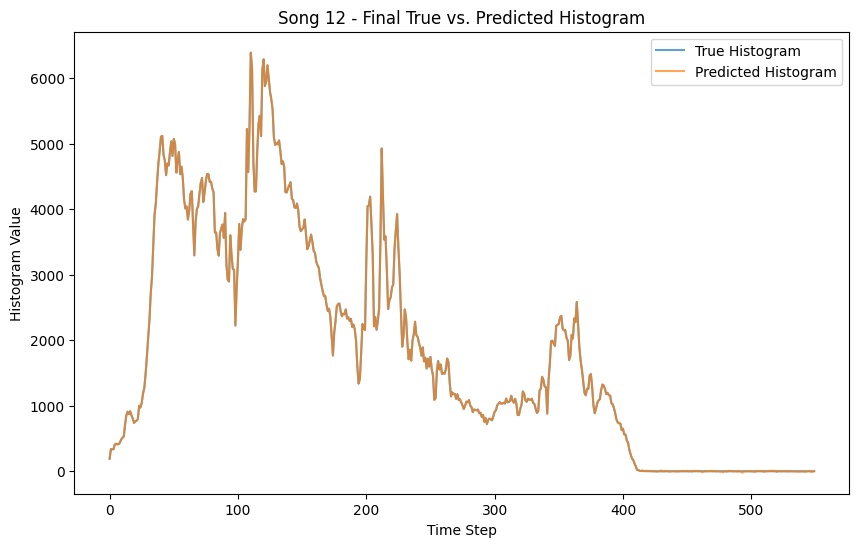

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Song 13 - Final Validation RMSE: 2.923685312271118


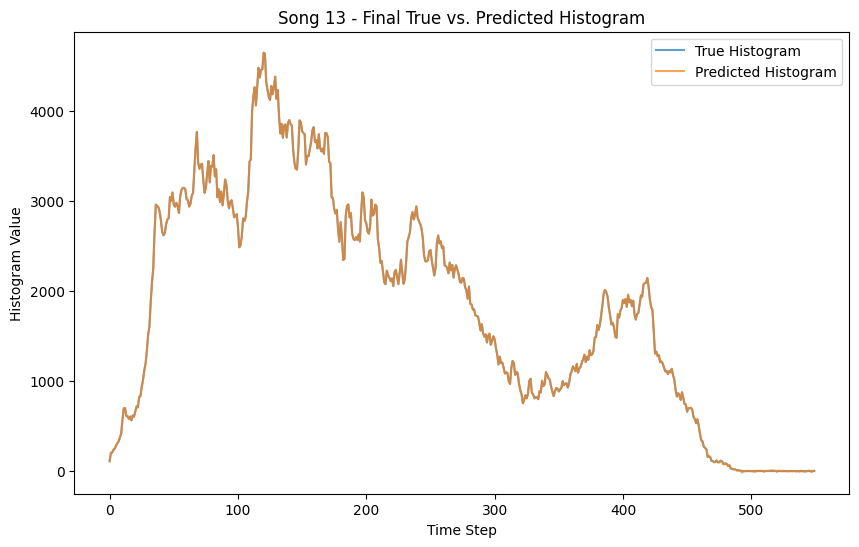

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Song 14 - Final Validation RMSE: 2.753995656967163


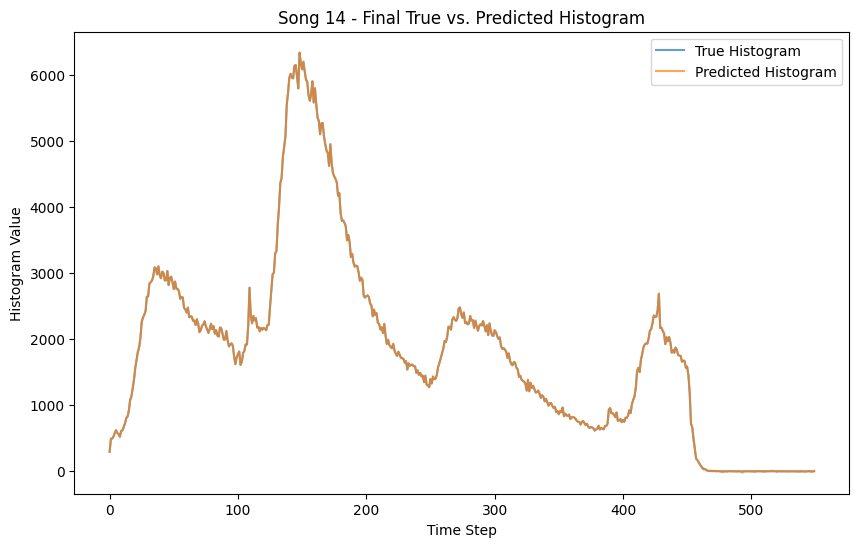

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Song 15 - Final Validation RMSE: 2.814018487930298


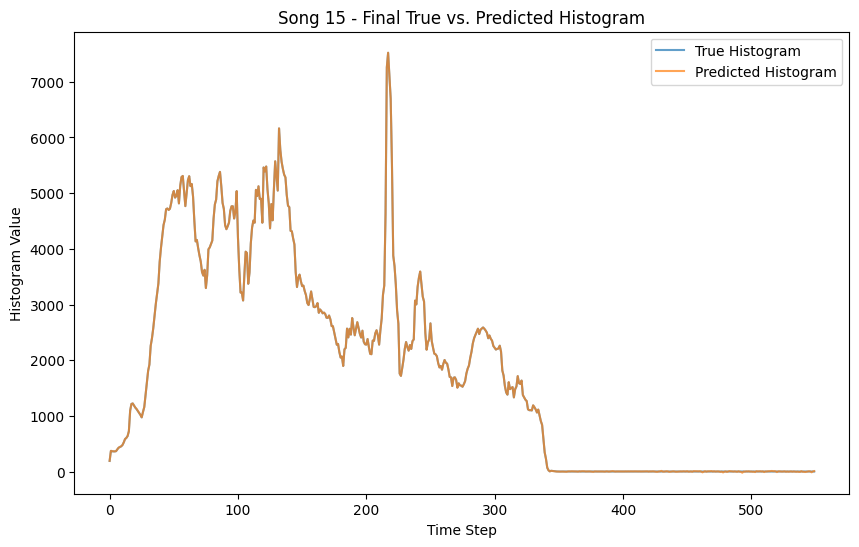

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Song 16 - Final Validation RMSE: 2.880836009979248


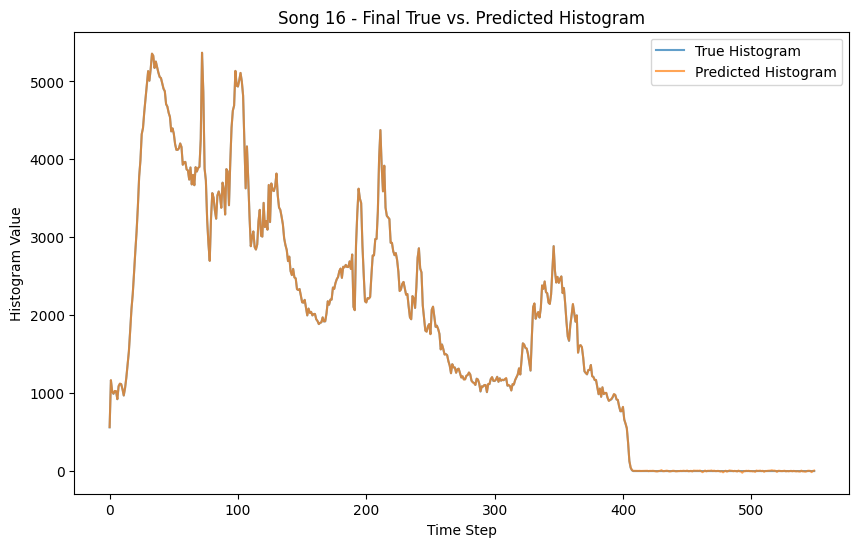

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Song 17 - Final Validation RMSE: 2.694937229156494


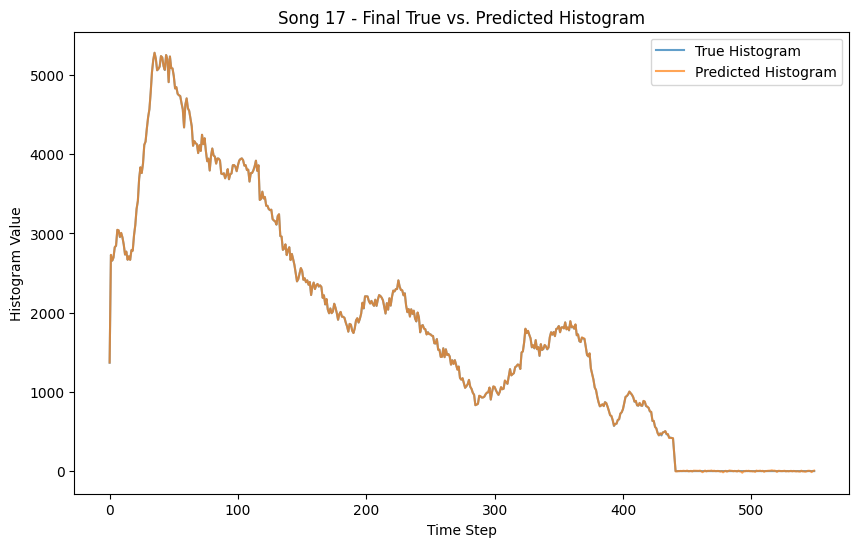

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Song 18 - Final Validation RMSE: 2.8035101890563965


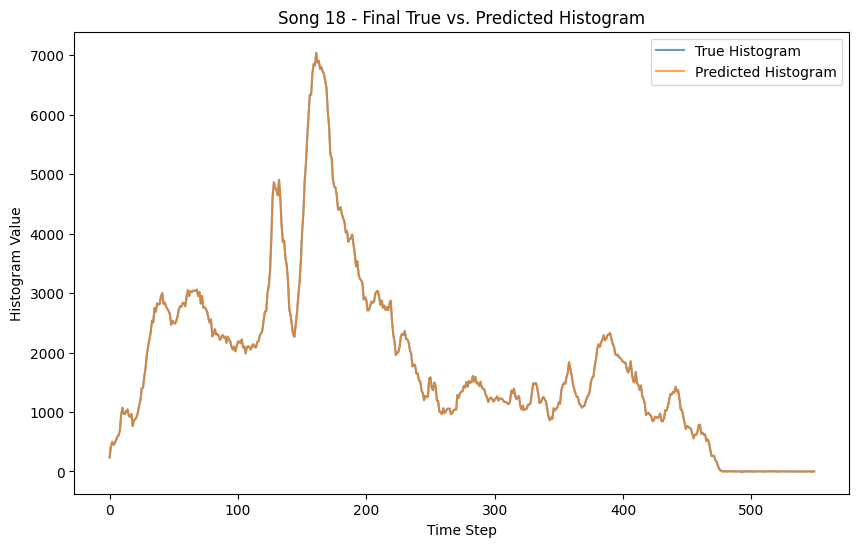

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Song 19 - Final Validation RMSE: 2.982532501220703


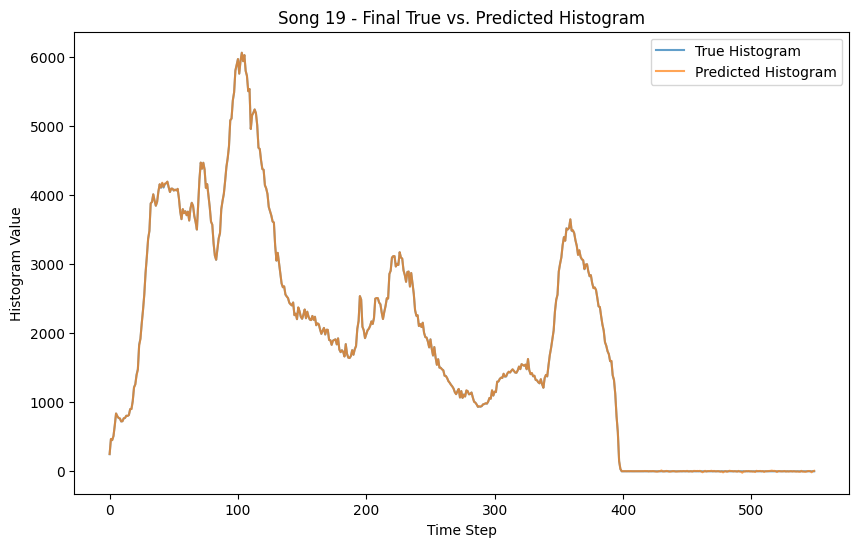

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Song 20 - Final Validation RMSE: 3.612363576889038


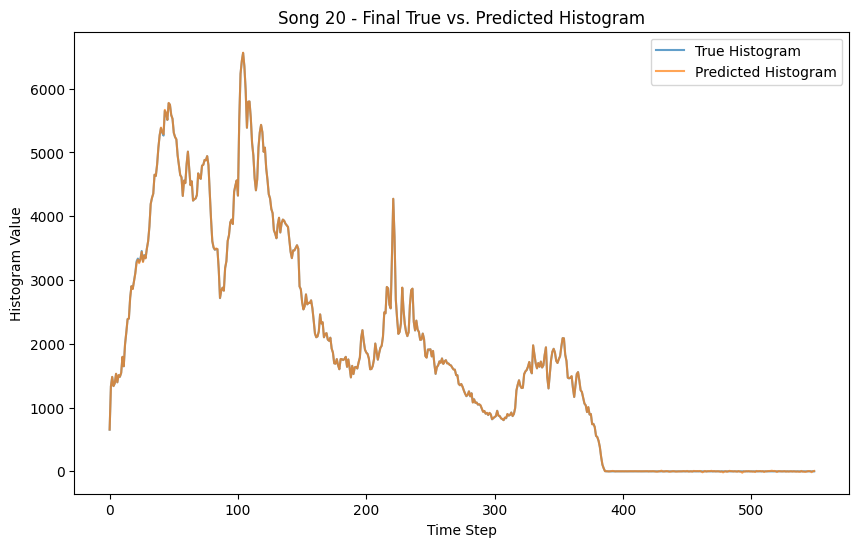

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Initialize Leave-One-Out cross-validator
loo = LeaveOneOut()

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(550, 27)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(550, activation='linear'))  # 550 max time steps
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Loop through each song for LOO CV and continue training
for train_index, test_index in loo.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    early_stopping = EarlyStopping(monitor='loss', patience=3)
    model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, callbacks=[early_stopping])

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test MSE for this fold: {loss}")

    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
    print(f"Test RMSE for this fold: {rmse}")

    # Plot the true vs. predicted histograms
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.flatten(), label='True Histogram', alpha=0.7)
    plt.plot(y_pred, label='Predicted Histogram', alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('Histogram Value')
    plt.title('True vs. Predicted Histogram')
    plt.legend()
    plt.show()

# Final Validation: Evaluate the model on all songs
#print("\n--- Final Validation ---")
#for i in range(len(X)):
    #y_pred_final = model.predict(np.expand_dims(X[i], axis=0)).flatten() #Need to add 1 to make it 3 parameters  again
    #rmse_final = np.sqrt(mean_squared_error(y[i].flatten(), y_pred_final))

    #print(f"Song {i+1} - Final Validation RMSE: {rmse_final}")

    # Plot the final true vs. predicted histograms
    #plt.figure(figsize=(10, 6))
    #plt.plot(y[i].flatten(), label='True Histogram', alpha=0.7)
    #plt.plot(y_pred_final, label='Predicted Histogram', alpha=0.7)
    #plt.xlabel('Time Step')
    #plt.ylabel('Histogram Value')
    #plt.title(f'Song {i+1} - Final True vs. Predicted Histogram')
    #plt.legend()
    #plt.show()
